In [73]:
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import scipy
import scipy.io as sio
from scipy import stats
import seaborn as sns
dirpath = os.getcwd()


## Reading data

In [74]:
# Get maxima from excel file and add to lists
file = os.path.join(dirpath, 'Localizer_Maxima_Thumb_Ringfinger.xlsx')
xl = pd.ExcelFile(file)
df = xl.sheet_names
df = xl.parse(0)
df.columns = df.iloc[1]
df = df.drop([0,1])
ring_maxima= []
thumb_maxima = []
for ma in range(len(df['Maxima Ring'])):
    ring = np.fromstring(df['Maxima Ring'][ma+2], dtype=int, sep=',')
    thumb = np.fromstring(df['Maxima Thumb'][ma+2], dtype=int, sep=',')
    #print(ring)
    ring_maxima.append(ring)
    thumb_maxima.append(thumb)
ring_maxima[:3]

/Users/pkf/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


[array([ 44, -26,  56]), array([ 44, -28,  60]), array([ 44, -24,  56])]

In [75]:
# Euclidean distance between both maxima per subject
maxima_dis = []
for rf, tb in zip(ring_maxima,thumb_maxima):
    # euclidean distance function
    dis = np.linalg.norm(rf-tb)
    maxima_dis.append(dis)
#maxima_dis

In [76]:
# Get subject paths
results_path = dirpath + '/searchlight_results_handmask'
files = [x[0] for x in os.walk(results_path)]
files = sorted(files)
nSubj = len(files[1:])
print('number of subjects:', nSubj)


number of subjects: 25


In [77]:
# if excel file already exists, open and ignore next steps
file = os.path.join(dirpath, 'Excel_SLdata.xlsx') #name)
xl = pd.ExcelFile(file)
df = xl.sheet_names
SL_df = xl.parse(0)

SL_df.head()

,Unnamed: 0,x,y,z,accuracy,ID,digit,condition,distance
0,0,48,-26,56,0.824209,0,1,0,4.000000
1,1,48,-24,56,0.817333,0,1,0,4.472136
2,2,48,-26,52,0.813570,0,1,0,5.656854
3,3,48,-24,52,0.813570,0,1,0,6.000000
4,4,44,-24,58,0.813570,0,1,0,2.828427


## Plotting

In [78]:
import seaborn as sns
import numpy as np
#current_palette = sns.palplot(sns.color_palette("YlGnBu", 10))
current_palette = sns.color_palette("YlGnBu", 3)
pcon = {"Congruent":current_palette[2],"Incongruent":current_palette[1],"Uninformative":current_palette[0]}
colors = ["#03818A", "#D4B611", "#68b9d4"]
colors = colors_box = ["#6eb574", "#d9a432",'#99c3e8']

#sns.palplot(colors)

In [79]:
max_mm = 25.
step_size = 2.5
splits = max_mm/step_size
steps = np.arange(0,max_mm+step_size,step_size)
steps

array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ])

/var/folders/b7/k9l5l5ss13d27wd57vb8fq4w0000gn/T/ipykernel_56987/2012542112.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels)


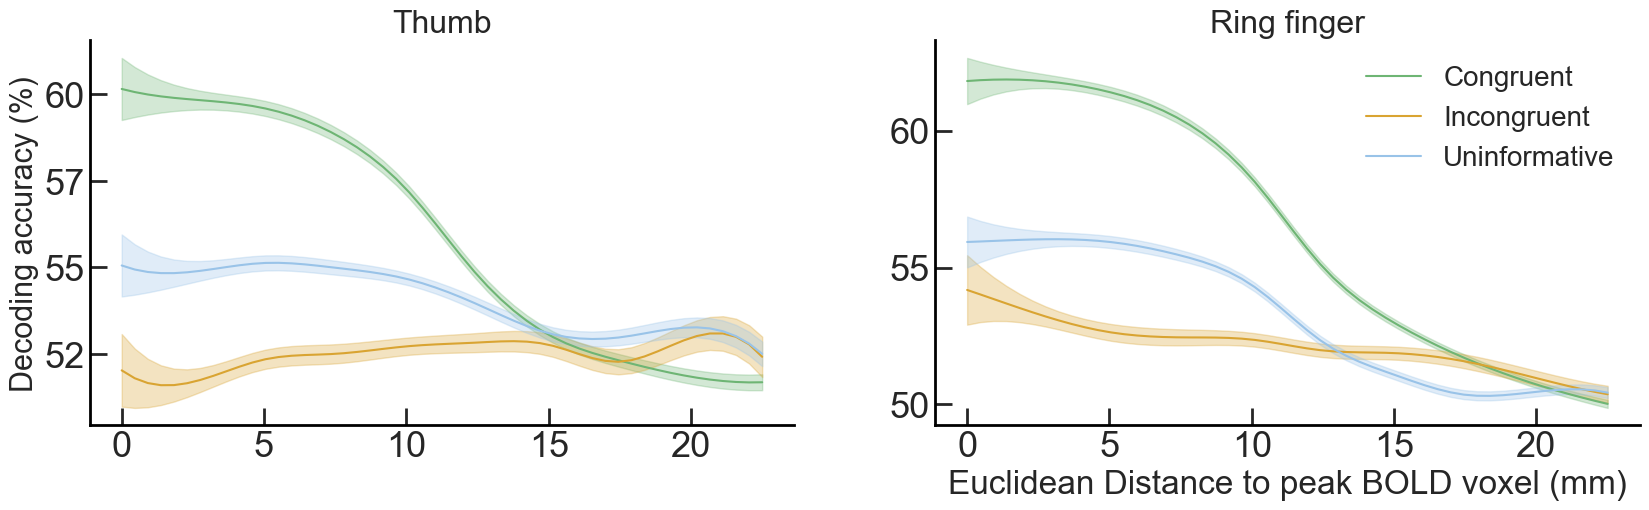

<Figure size 640x480 with 0 Axes>

In [80]:
std_rate = 1.5 #set to 1 for the default value
interpolated_size = 50 #number of points per function, default is 10

colors_shade = ['turquoise', 'khaki', 'lightcoral']
#di = ['ringfinger','thumb']
font = {'family': 'arial',
        'weight': 'normal',
        'size': 28,
        }
font_title = {'family': 'arial',
        'color':  'dimgray',
        'weight': 'normal',
        'size': 28,
        }
labels = ['Congruent', 'Incongruent', 'Uninformative']
const_lbls = labels
dtxt = ['Thumb', 'Ring finger']

fig, ax = plt.subplots(1,2)
fig.set_size_inches(20,5)
fig.suptitle('ROI-based decoding | Euclidean distances across conditions', fontsize=28, fontweight='regular',  ha ='center', va='baseline') 
fig.suptitle('', fontsize=28, fontweight='regular',  ha ='center', va='baseline') 

res = {}

for finger in range(2):
    res[dtxt[finger]] = {}
    dt = SL_df[SL_df['digit']==finger]
    ax1 = ax[finger]
    sns.set_style("whitegrid", {'axes.grid' : False})
    for condition in range(3):
        data = dt[dt['condition']==condition]
        Y = []
        STD = []
        for sp in range(len(steps)):
            #print(steps[sp+1])
            da = data[data['distance'].between(steps[sp],steps[sp+1])]
            inty = da['accuracy'].mean()
            #print(inty)
            inty_std = stats.sem(da['accuracy'])
            Y.append(inty)
            STD.append(inty_std*std_rate)
            
            if steps[sp+1] == 25:
                break
        x_data = np.linspace(steps[0], steps[-2], num=interpolated_size, endpoint=True)
        f_y = interp1d(steps[:-1], Y, kind='cubic')
        f_sub = interp1d(steps[:-1], np.subtract(Y,STD), kind='cubic')
        f_add = interp1d(steps[:-1], np.add(Y,STD), kind='cubic')
        y_data = f_y(x_data)
        sub_data = f_sub(x_data)
        add_data = f_add(x_data)
        
        ax1.plot(x_data,y_data, color=colors[condition], label=labels[condition])
        ax1.fill_between(x_data, sub_data, add_data, color=colors[condition], alpha=0.3)
        ax1.tick_params(axis='both', labelsize=26)
        
        res[dtxt[finger]][const_lbls[condition]] = y_data
    ax1.set_title(dtxt[finger])
    ax1.set_title(dtxt[finger],fontdict={'fontsize':23, 'family': 'Arial'})
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['bottom'].set_linewidth(2)
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_edgecolor('black')
    ax1.spines['left'].set_edgecolor('black')
    if finger == 0:
        _lines, _labels = ax1.get_legend_handles_labels()  
        ax1.set_ylabel('Decoding accuracy (%)',fontdict=font, fontsize=22)
    else:
        ax1.legend(_lines,_labels,fontsize=20,frameon=False)
    labels = []
    for label in ax1.get_yticklabels():
        label.set_text(str(int(float(label.get_text())*100)))
        labels.append(label)
    ax1.set_yticklabels(labels)
    
    ax1.tick_params(axis='y', which='both', left=True, direction='in', width=2, length=12)
    ax1.tick_params(axis='x', which='both', bottom=True, direction='in', width=2, length=12)
    plt.xlabel('Euclidean Distance to peak BOLD voxel (mm)',fontdict=font, fontsize=24)

plt.show()
fig.set_size_inches([6,6])

fig.savefig("Decoding_Euclidean_3.jpg",dpi=600,bbox_inches='tight')
plt.savefig('Decoding_Euclidean_3.eps', format='eps', dpi=600)

In [81]:
xdict = {'x':x_data}


In [82]:
thumb_df = pd.DataFrame.from_dict(res["Thumb"])
finger_df = pd.DataFrame.from_dict(res["Ring finger"])
x_df = pd.DataFrame.from_dict(xdict)

In [83]:
newdf = pd.concat([thumb_df,finger_df,x_df],axis=1,keys=["Thumb","Ring finger","X"])
newdf.to_csv('data_fig_acc_dist.csv')

In [84]:
loaded_df = pd.read_csv('data_fig_acc_dist.csv',header=[0,1],index_col=0)
for _type in const_lbls:
    loaded_df[('Average',_type)] = loaded_df.get([('Thumb',_type),('Ring finger',_type)]).mean(axis=1)
loaded_df.to_csv('data_fig_acc_dist_avg.csv')

In [85]:
loaded_df

Thumb                           Ring finger                            \
   Congruent Incongruent Uninformative   Congruent Incongruent Uninformative   
0   0.601543    0.520211      0.550524    0.618070    0.541810      0.559320   
1   0.600642    0.517925      0.549353    0.618383    0.540180      0.559500   
2   0.599940    0.516538      0.548640    0.618571    0.538527      0.559700   
3   0.599395    0.515920      0.548316    0.618629    0.536872      0.559899   
4   0.598968    0.515947      0.548310    0.618554    0.535239      0.560080   
5   0.598618    0.516488      0.548551    0.618340    0.533651      0.560224   
6   0.598305    0.517419      0.548969    0.617984    0.532129      0.560313   
7   0.597989    0.518609      0.549495    0.617481    0.530697      0.560329   
8   0.597630    0.519933      0.550057    0.616827    0.529377      0.560252   
9   0.597188    0.521263      0.550585    0.616017    0.528192      0.560065   
10  0.596623    0.522471      0.551009    0.615047    0.527165      0.559749   
11  0.595894    0.523429      0.551259    0.613913    0.526318      0.559285   
12  0.594968    0.524061      0.551291    0.612602    0.525663      0.558663   
13  0.593833    0.524433      0.551137    0.611081    0.525180      0.557891   
14  0.592481    0.524638      0.550844    0.609310    0.524846      0.556981   
15  0.590901    0.524768      0.550458    0.607253    0.524634      0.555947   
16  0.589087    0.524916      0.550025    0.604870    0.524521      0.554802   
17  0.587026    0.525168      0.549587    0.602123    0.524481      0.553552   
18  0.584688    0.525531      0.549138    0.598968    0.524467      0.552139   
19  0.582025    0.525962      0.548639    0.595355    0.524427      0.550464   
20  0.578994    0.526416      0.548051    0.591237    0.524302      0.548427   
21  0.575547    0.526849      0.547338    0.586565    0.524037      0.545927   
22  0.571640    0.527217      0.546458    0.581290    0.523577      0.542864   
23  0.567290    0.527496      0.545393    0.575454    0.522909      0.539237   
24  0.562648    0.527709      0.544159    0.569287    0.522111      0.535254   
25  0.557882    0.527880      0.542775    0.563038    0.521273      0.531145   
26  0.553160    0.528037      0.541264    0.556960    0.520484      0.527145   
27  0.548648    0.528205      0.539646    0.551306    0.519833      0.523486   
28  0.544502    0.528404      0.537946    0.546299    0.519398      0.520372   
29  0.540767    0.528578      0.536223    0.541940    0.519156      0.517787   
30  0.537437    0.528641      0.534554    0.538127    0.519034      0.515610   
31  0.534506    0.528507      0.533012    0.534754    0.518964      0.513719   
32  0.531969    0.528088      0.531674    0.531717    0.518872      0.511993   
33  0.529817    0.527300      0.530615    0.528911    0.518689      0.510310   
34  0.528024    0.526173      0.529873    0.526269    0.518372      0.508628   
35  0.526525    0.524919      0.529431    0.523776    0.517921      0.507026   
36  0.525253    0.523768      0.529269    0.521422    0.517338      0.505594   
37  0.524144    0.522947      0.529365    0.519198    0.516629      0.504421   
38  0.523129    0.522683      0.529697    0.517095    0.515797      0.503597   
39  0.522153    0.523151      0.530235    0.515103    0.514847      0.503190   
40  0.521212    0.524230      0.530894    0.513218    0.513798      0.503151   
41  0.520320    0.525693      0.531567    0.511433    0.512674      0.503388   
42  0.519493    0.527315      0.532152    0.509744    0.511497      0.503810   
43  0.518746    0.528868      0.532543    0.508147    0.510291      0.504327   
44  0.518092    0.530129      0.532637    0.506637    0.509079      0.504848   
45  0.517549    0.530871      0.532328    0.505208    0.507883      0.505282   
46  0.517130    0.530867      0.531513    0.503856    0.506728      0.505538   
47  0.516850    0.529892      0.530086    0.502577    0.505635      0.505526   
48  0.5

In [86]:
avg_df = pd.concat([loaded_df['Average'],loaded_df['X']],axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


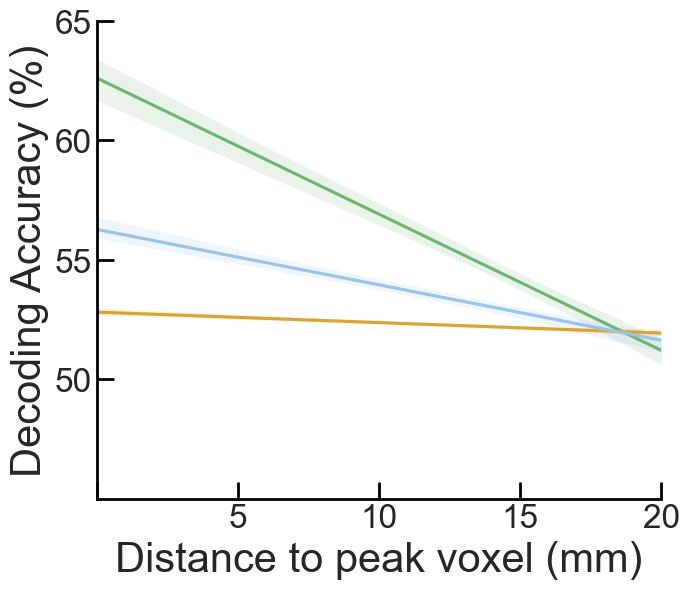

In [87]:
fig, axis = plt.subplots()

sns.regplot(data=avg_df,x='x',y='Congruent',marker='',ax=axis,color=colors[0],ci=100,label='Congruent')
sns.regplot(data=avg_df,x='x',y='Incongruent',marker='',ax=axis,color=colors[1],ci=100,label='Incongruent')
sns.regplot(data=avg_df,x='x',y='Uninformative',marker='',ax=axis,color=colors[2],ci=100,label='Uninformative')

axis.spines['right'].set_visible(False)
axis.spines['top'].set_visible(False)
axis.spines['left'].set_linewidth(2)
axis.spines['bottom'].set_linewidth(2)
axis.spines['bottom'].set_color('black')
axis.spines['left'].set_color('black')
#plt.axhline(0.5,linewidth=1.5, color='grey',ls='--')


axis.set_ylim([0.45,0.65])
axis.set_yticks([0.5,0.55,0.6,0.65], fontname='Arial')
axis.set_yticklabels(['50','55','60','65'],fontname='Arial')

axis.set_xlim([0,20])
axis.set_xticks([0,5,10,15,20], fontname='Arial')
axis.set_xticklabels(['','5','10','15','20'],fontname='Arial')

axis.tick_params(which='major',reset=True, direction='in',length=12, labelsize=24, width=2, color='black', top=False, right=False)

axis.set_ylabel("Decoding Accuracy (%)",fontsize=30, fontname='Arial')
axis.set_xlabel("Distance to peak voxel (mm)",fontsize=30, fontname='Arial')

fig = axis.get_figure()

axis.legend(frameon=False)
axis.legend().remove()

fig.set_size_inches([7,6])


plt.tight_layout()
fig.tight_layout()
fig.savefig("Fig3D_SL_Distance.jpg",dpi=600, bbox_inches='tight')
plt.savefig('Fig3D_SL_Distance.eps', format='eps', dpi=600)

In [88]:
test_avg = loaded_df[['Average','X']]

In [89]:
data[data['digit']==1][data['condition']==2][data['ID']==1]

,Unnamed: 0,x,y,z,accuracy,ID,digit,condition,distance
10268,10268,22,-24,72,0.707071,1,1,2,25.377155
10269,10269,24,-26,72,0.690657,1,1,2,23.409400
10270,10270,22,-28,74,0.688131,1,1,2,26.076810
10271,10271,24,-28,74,0.683081,1,1,2,24.413111
10272,10272,24,-28,70,0.676768,1,1,2,22.360680
...,...,...,...,...,...,...,...,...,...
12262,12262,28,-32,60,0.410354,1,1,2,16.492423
12273,12273,30,-22,64,0.401515,1,1,2,15.748016
12278,12278,10,-28,74,0.398990,1,1,2,36.769553
12279,12279,24,-26,62,0.397727,1,1,2,20.199010


In [90]:
SL_df

,Unnamed: 0,x,y,z,accuracy,ID,digit,condition,distance
0,0,48,-26,56,0.824209,0,1,0,4.000000
1,1,48,-24,56,0.817333,0,1,0,4.472136
2,2,48,-26,52,0.813570,0,1,0,5.656854
3,3,48,-24,52,0.813570,0,1,0,6.000000
4,4,44,-24,58,0.813570,0,1,0,2.828427
...,...,...,...,...,...,...,...,...,...
156457,156457,30,-28,68,0.363656,24,1,2,23.065125
156458,156458,28,-30,66,0.353452,24,1,2,24.494897
156459,156459,48,-12,40,0.344116,24,0,2,6.324555
156460,156460,48,-10,40,0.343682,24,0,2,6.633250
